## <div style="text-align: left; background-color:orange;  color : black ; padding: 15px; line-height:1;border-radius:5px; margin-bottom: 0em; text-align: center; font-size: 28px;"><strong>Import Required Libraries</strong></div> 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

from xgboost import XGBRegressor
from xgboost import plot_importance

from fbprophet import Prophet

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings('ignore')

## <div style="text-align: left; background-color:orange;  color : black ; padding: 15px; line-height:1;border-radius:5px; margin-bottom: 0em; text-align: center; font-size: 28px;"><strong>Data Description</strong></div> 
The data I am using is hourly power consumption data from PJM which has data from 2002-2018 for the entire east region.

## <div style="text-align: left; background-color:orange;  color : black ; padding: 15px; line-height:1;border-radius:5px; margin-bottom: 0em; text-align: center; font-size: 28px;"><strong>Load the Data</strong></div> 

In [2]:
df_pjme = pd.read_csv('./Data/PJME_hourly.csv',
                  index_col=[0],
                  parse_dates=[0])

# checking the first five rows of data
df_pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [3]:
# lets check missing values in the dataset
df_pjme.isnull().sum()

PJME_MW    0
dtype: int64

<div class="alert alert-success" role="alert">
<p style="color:black; font-size:16px;  ">No Missing values Found!!</p></div>   


## <div style="text-align: left; background-color:orange;  color : black ; padding: 15px; line-height:1;border-radius:5px; margin-bottom: 0em; text-align: center; font-size: 28px;"><strong>Exploratory Data Analysis</strong></div> 

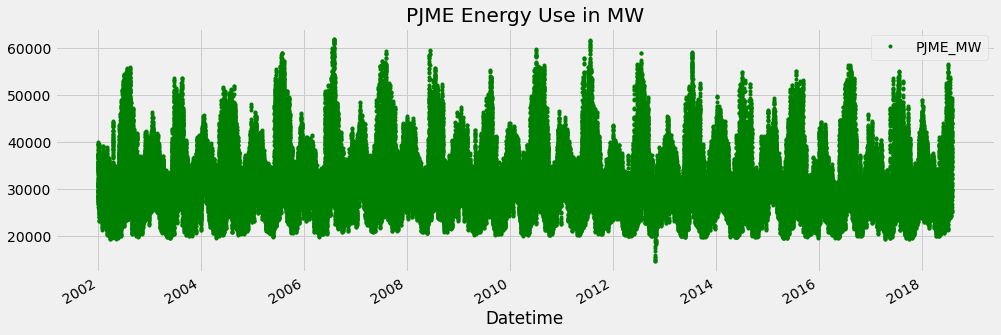

In [4]:
df_pjme.plot(style='.',
        figsize=(15, 5),
        color='green',
        title='PJME Energy Use in MW')
plt.show()

### 1. Distribution of PJME_MW

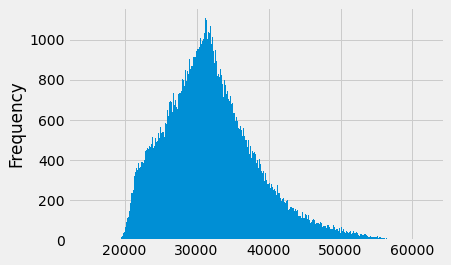

In [5]:
# Data Distribution
df_pjme['PJME_MW'].plot(kind='hist', bins=500)
plt.show()

### 2. Outlier Analysis in Target Variable

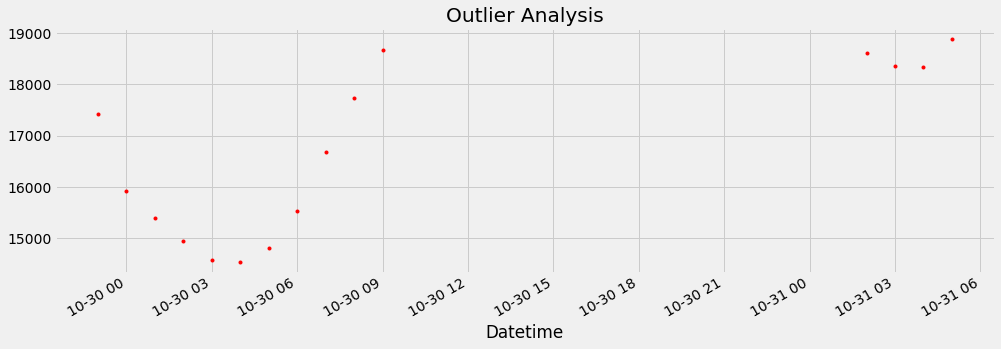

In [6]:
df_pjme.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color='r',
          title='Outlier Analysis')

plt.show()

In [7]:
df_pjme = df_pjme.query('PJME_MW > 19_000').copy()

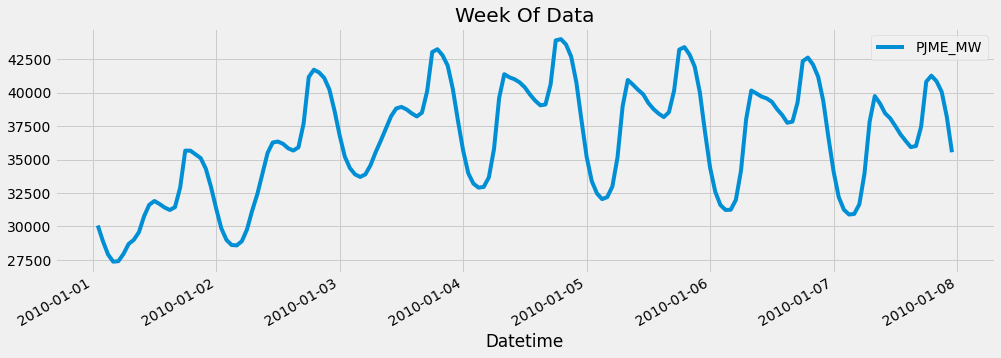

In [8]:
df_pjme.loc[(df_pjme.index > '01-01-2010') & (df_pjme.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

## <div style="text-align: left; background-color:orange;  color : black ; padding: 15px; line-height:1;border-radius:5px; margin-bottom: 0em; text-align: center; font-size: 28px;"><strong>Train Test Split</strong></div> 

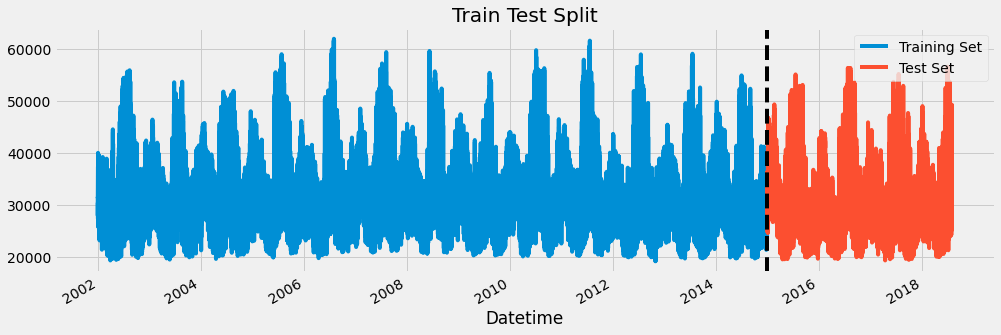

In [9]:
train_df = df_pjme.loc[df_pjme.index < '01-01-2015']
test_df = df_pjme.loc[df_pjme.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train_df.plot(ax=ax, label='Training Set', title='Train Test Split')
test_df.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [10]:
# lets create some more features 
def create_features(data):
    """
    Create time series features based on time series index.
    """
    df = data.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df_pjme = create_features(df_pjme)

### 3.  Analysis of Hour and PJME_MW (Target Var)

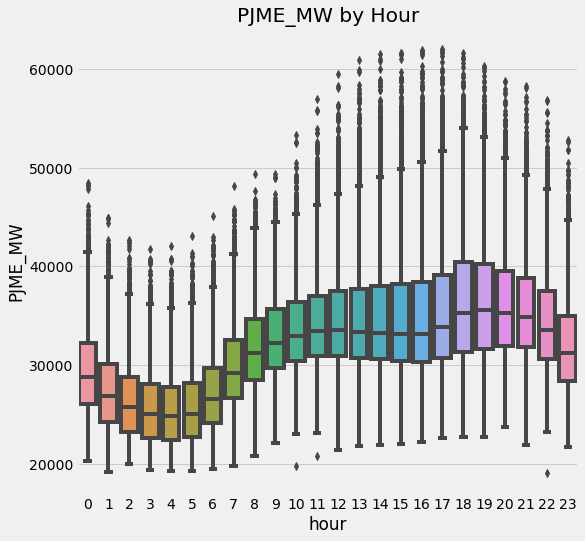

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.boxplot(data=df_pjme, x='hour', y='PJME_MW')
ax.set_title('PJME_MW by Hour')
plt.show()

### 4.  Analysis of Month and PJME_MW (Target Var)

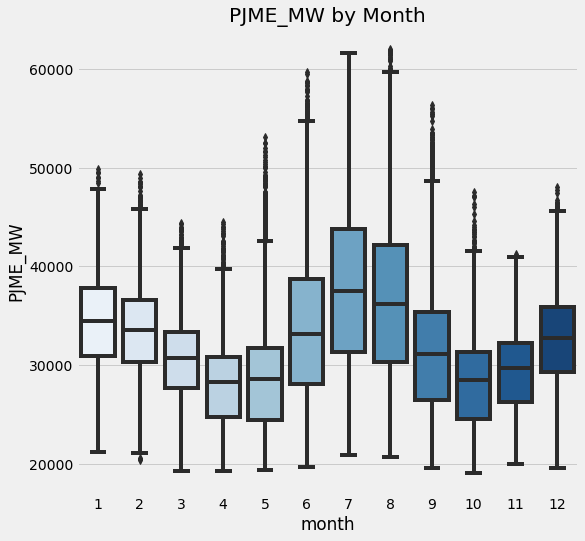

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.boxplot(data=df_pjme, x='month', y='PJME_MW', palette='Blues')
ax.set_title('PJME_MW by Month')
plt.show()

## <div style="text-align: left; background-color:orange;  color : black ; padding: 15px; line-height:1;border-radius:5px; margin-bottom: 0em; text-align: center; font-size: 28px;"><strong>Base Model</strong></div> 

In [13]:
train_df = create_features(train_df)
test_df = create_features(test_df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train_df[FEATURES]
y_train = train_df[TARGET]

X_test = test_df[FEATURES]
y_test = test_df[TARGET]

In [14]:
xgb_reg = XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=5,
                       learning_rate=0.01,
                       random_state = 2023)
xgb_reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[21:03:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[21:03:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:32603.90039	validation_1-rmse:31654.49609
[100]	validation_0-rmse:12387.12402	validation_1-rmse:11518.73535
[200]	validation_0-rmse:5464.98535	validation_1-rmse:5094.07031
[300]	validation_0-rmse:3510.91431	validation_1-rmse:3785.11377
[400]	validation_0-rmse:3025.65503	validation_1-rmse:3689.17969
[500]	validation_0-rmse:2872.39429	validation_1-rmse:3727.14966
[600]	validation_0-rmse:2788.71436	val

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', random_state=2023,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Feature Importance

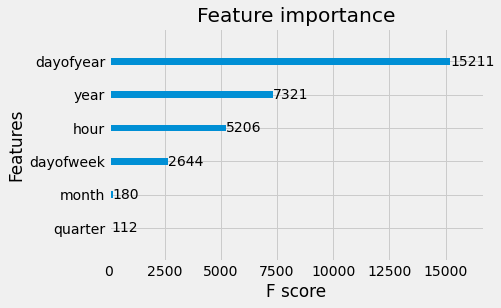

In [15]:
# plot feature importance
plot_importance(xgb_reg)
plt.show()

### Forecast on Test¶

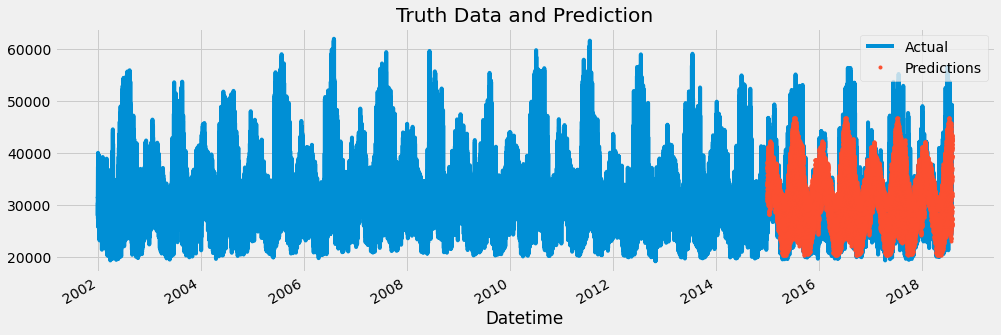

In [16]:
test_df['prediction'] = xgb_reg.predict(X_test)
df_pjme_with_test = df_pjme.merge(test_df[['prediction']], how='left', left_index=True, right_index=True)
ax = df_pjme_with_test[['PJME_MW']].plot(figsize=(15, 5))
df_pjme_with_test['prediction'].plot(ax=ax, style='.')
plt.legend(['Actual', 'Predictions'])
ax.set_title('Truth Data and Prediction')
plt.show()

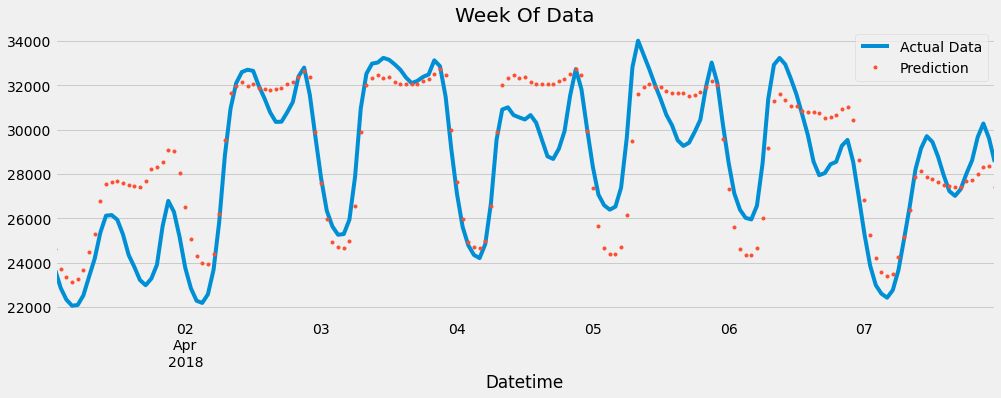

In [17]:
ax = df_pjme_with_test.loc[(df_pjme_with_test.index > '04-01-2018') & (df_pjme_with_test.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df_pjme_with_test.loc[(df_pjme_with_test.index > '04-01-2018') & (df_pjme_with_test.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Actual Data','Prediction'])
plt.show()

In [18]:
base_score = np.sqrt(mean_squared_error(test_df['PJME_MW'], test_df['prediction']))
print(f'RMSE Score on Test set: {base_score:0.2f}')

RMSE Score on Test set: 3845.28


In [19]:
# lets introduce Lag in our data --
# Lag : What was the target (x) days in the past

def create_lags(data):
    df = data.copy()
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

df_pjme = create_lags(df_pjme)

## <div style="text-align: left; background-color:orange;  color : black ; padding: 15px; line-height:1;border-radius:5px; margin-bottom: 0em; text-align: center; font-size: 28px;"><strong>Time Series Cross Validation</strong></div> 

In [20]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df_pjme = df_pjme.sort_index()

fold = 0
preds = []
scores_list = []
for train_idx, val_idx in tss.split(df_pjme):
    train_df = df_pjme.iloc[train_idx]
    test_df = df_pjme.iloc[val_idx]

    train_df = create_features(train_df)
    test_df = create_features(test_df)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train_df[FEATURES]
    y_train = train_df[TARGET]

    X_test = test_df[FEATURES]
    y_test = test_df[TARGET]

    reg_cv = XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=5,
                           learning_rate=0.01,
                           random_state = 2023)
    reg_cv.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg_cv.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores_list.append(score)

[21:04:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[21:04:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:32731.68750	validation_1-rmse:31955.93164
[100]	validation_0-rmse:12443.25391	validation_1-rmse:11952.30176
[200]	validation_0-rmse:5491.93213	validation_1-rmse:5491.19531
[300]	validation_0-rmse:3521.34131	validation_1-rmse:3956.63769
[400]	validation_0-rmse:3067.20972	validation_1-rmse:3766.58008
[500]	validation_0-rmse:2908.55078	validation_1-rmse:3774.95239
[600]	validation_0-rmse:2818.00659	val

In [21]:
print(f'Score across folds {np.mean(scores_list):0.4f}')
print(f'Fold scores:{scores_list}')

Score across folds 3766.0582
Fold scores:[3720.061855659048, 3317.0078412962935, 3872.2543773444545, 3911.1183211239913, 4009.8484145606053]


## <div style="text-align: left; background-color:orange;  color : black ; padding: 15px; line-height:1;border-radius:5px; margin-bottom: 0em; text-align: center; font-size: 28px;"><strong>Predict the Future</strong></div> 

In [22]:
# Retrain on all data
df_pjme = create_features(df_pjme)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X = df_pjme[FEATURES]
y = df_pjme[TARGET]

reg = XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=1000,
                       objective='reg:linear',
                       max_depth=5,
                       learning_rate=0.01,
                       random_state = 2023)
reg.fit(X, y,
        eval_set=[(X, y)],
        verbose=100)

[21:15:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32403.10742
[100]	validation_0-rmse:12351.12012
[200]	validation_0-rmse:5541.19873
[300]	validation_0-rmse:3657.80640
[400]	validation_0-rmse:3247.58960
[500]	validation_0-rmse:3112.62646
[600]	validation_0-rmse:3033.76343
[700]	validation_0-rmse:2981.56445
[800]	validation_0-rmse:2927.45581
[900]	validation_0-rmse:2879.78735
[999]	validation_0-rmse:2843.07861
[21:17:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:linear', random_state=2023, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [23]:
# Create future dataframe
future_dates = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future_dates)
future_df['isFuture'] = True
df_pjme['isFuture'] = False
df_pjme_future = pd.concat([df_pjme, future_df])
df_pjme_future = create_features(df_pjme_future)
df_pjme_future = create_lags(df_pjme_future)

In [24]:
future_features = df_pjme_future.query('isFuture').copy()

In [25]:
future_features['pred'] = reg.predict(future_features[FEATURES])

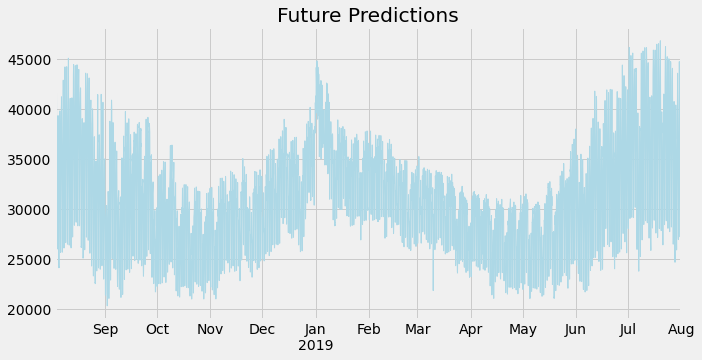

In [26]:
future_features['pred'].plot(figsize=(10, 5),
                               color='lightblue',
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()